<a href="https://colab.research.google.com/github/snufkin92/colab_tutorial/blob/master/section_07/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ●CNNの実装
Kerasを使い、CNNを実装します。  
今回はCIFAR-10というデータセットを使い、画像の分類を行います。

## ●CIFAR-10
Kerasを使い、CIFAR-10を読み込みます。  
CIFARは、約6万枚の画像にラベルをつけたたデータセットです。  
以下のコードでは、CIFAR-10を読み込み、ランダムな25枚の画像を表示します。

Image size: (32, 32, 3)
[15795   860 38158 44732 11284  6265 16850 37194 21962 47191 44131 16023
 41090  1685   769  2433  5311 37819 39188 17568 19769 28693  6396 27480
 41434]


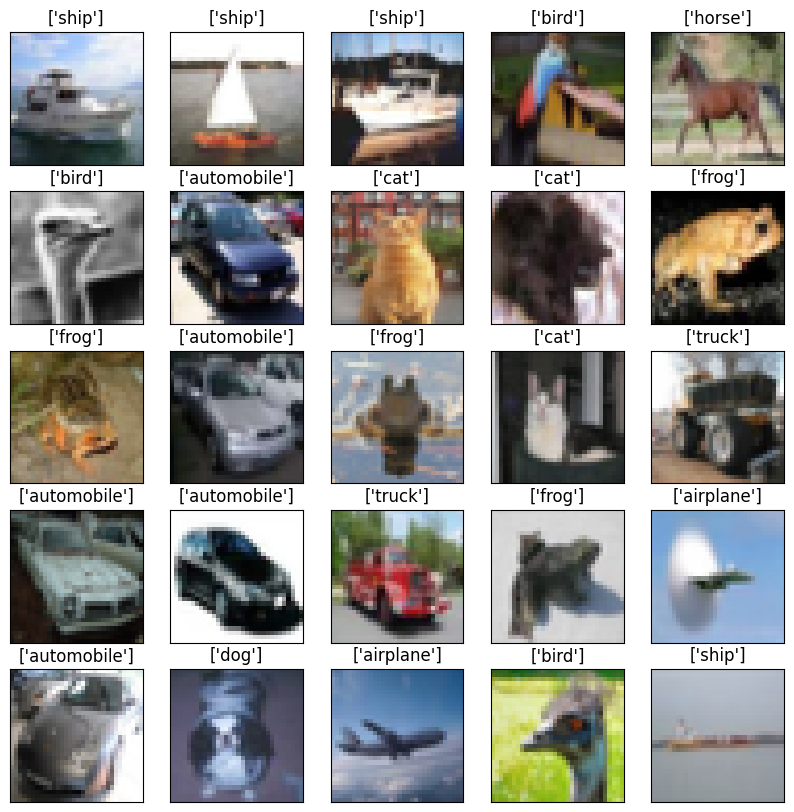

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10

(x_train, t_train), (x_test, t_test) = cifar10.load_data()
print("Image size:", x_train[0].shape)

cifar10_labels = np.array(["airplane", "automobile", "bird", "cat", "deer",
                           "dog", "frog", "horse", "ship", "truck"])

n_image = 25

np.random.seed(42)

# seedをセットして　0以上 len(x_train) 未満 の整数を n_image 個生成
rand_idx = np.random.randint(0, len(x_train), n_image)
print(rand_idx)

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(x_train[rand_idx[i]])
    label = cifar10_labels[t_train[rand_idx[i]]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

In [33]:
# クラスは10種類
print(np.unique(t_train))

# クラスラベル
print(cifar10_labels)

# ランダムに取り出した最初の画像のCIFAR-10内でのインデックス番号
img1_idx = t_train[rand_idx[0]]
print(img1_idx, cifar10_labels[img1_idx])

[0 1 2 3 4 5 6 7 8 9]
['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']
[8] ['ship']


## ●各設定
CNNの各設定を行います。  
また、ラベルをone-hot表現に変換します。  
one-hot表現は、クラスの数だけ要素のあるベクトルで、正解の値は1でそれ以外は0になります。  
例: (0 0 0 1 0 0 0 0 0 0)

In [34]:
batch_size = 32
epochs = 20
n_class = 10  # 10のクラスに分類

# one-hot表現に変換
print(t_train[:5])

t_train = keras.utils.to_categorical(t_train, n_class)
t_test = keras.utils.to_categorical(t_test, n_class)
print(t_train[:10])

[[6]
 [9]
 [9]
 [4]
 [1]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## ●モデルの構築
CNNのモデルを構築します。  
今回は、以下の順に複数の層を並べます。  

------------------------  
畳み込み層  
畳み込み層  
Maxプーリング層  
畳み込み層  
畳み込み層  
Maxプーリング層  
全結合層  
全結合層  

------------------------  

また、中間層である全結合層の直後にドロップアウトを挟みます。  
ドロップアウトはランダムにニューロンを無効にするテクニックですが、これによりモデルの汎化性能が向上します

In [36]:
# 5000枚の画像、各画像のサイズは32×32 で3チャネル
x_train.shape

(50000, 32, 32, 3)

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

model = Sequential()

# 3×3のフィルタを32個用意、パッディングは0、 input_shapeは（縦、横、チャネル）＝（32, 32, 3）
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))  # ゼロパディング、バッチサイズ以外の画像の形状を指定
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # 画像を一次元の配列に変換
model.add(Dense(256)) # 256個のニューロンに変換
model.add(Activation('relu'))
model.add(Dropout(0.5))  # ドロップアウト(256個のニューロンの半分がランダムで利用される）
model.add(Dense(n_class)) # 10個のクラスを表現
model.add(Activation('softmax')) # 各クラスの確率を出力

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 64)        18496     
                                                      

## ●学習
モデルを訓練します。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

In [38]:
x_train = x_train / 255  # 0から1の範囲に収める
x_test = x_test / 255

history = model.fit(x_train, t_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_test, t_test))

Epoch 1/20
1563/1563 [==============================] - 15s 6ms/step - loss: 1.4849 - accuracy: 0.4614 - val_loss: 1.1443 - val_accuracy: 0.5955
Epoch 2/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0680 - accuracy: 0.6248 - val_loss: 0.9038 - val_accuracy: 0.6888
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8904 - accuracy: 0.6896 - val_loss: 0.8254 - val_accuracy: 0.7142
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7902 - accuracy: 0.7242 - val_loss: 0.7912 - val_accuracy: 0.7262
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7156 - accuracy: 0.7501 - val_loss: 0.7457 - val_accuracy: 0.7409
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6555 - accuracy: 0.7685 - val_loss: 0.7878 - val_accuracy: 0.7405
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5981 - accuracy: 0.7881 - val_loss: 0.7202 - val_accuracy

## ●学習の推移
Historyには学習の経過が記録されています。  
これを使って、学習の推移を表示します。

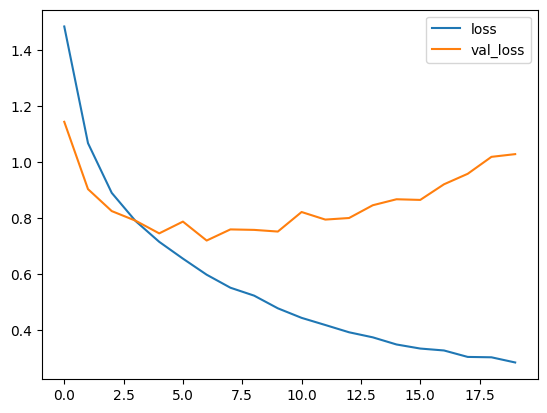

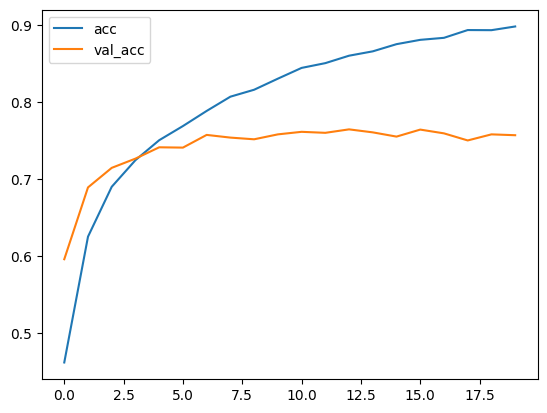

In [39]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']  # 訓練用データの誤差
train_acc = history.history['accuracy']  # 訓練用データの精度
val_loss = history.history['val_loss']  # 検証用データの誤差
val_acc = history.history['val_accuracy']  # 検証用データの精度

plt.plot(np.arange(len(train_loss)), train_loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label='acc')
plt.plot(np.arange(len(val_acc)), val_acc, label='val_acc')
plt.legend()
plt.show()

val_acc を見ると 過学習気味

## ●評価
モデルの評価を行います。  

In [40]:
loss, accuracy = model.evaluate(x_test, t_test)
print(loss, accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.0288 - accuracy: 0.7566
1.0288407802581787 0.756600022315979


精度は約75.7%

## ●予測
学習済みのモデルを使って予測を行います。  

1/1 [==============================] - 0s 30ms/step


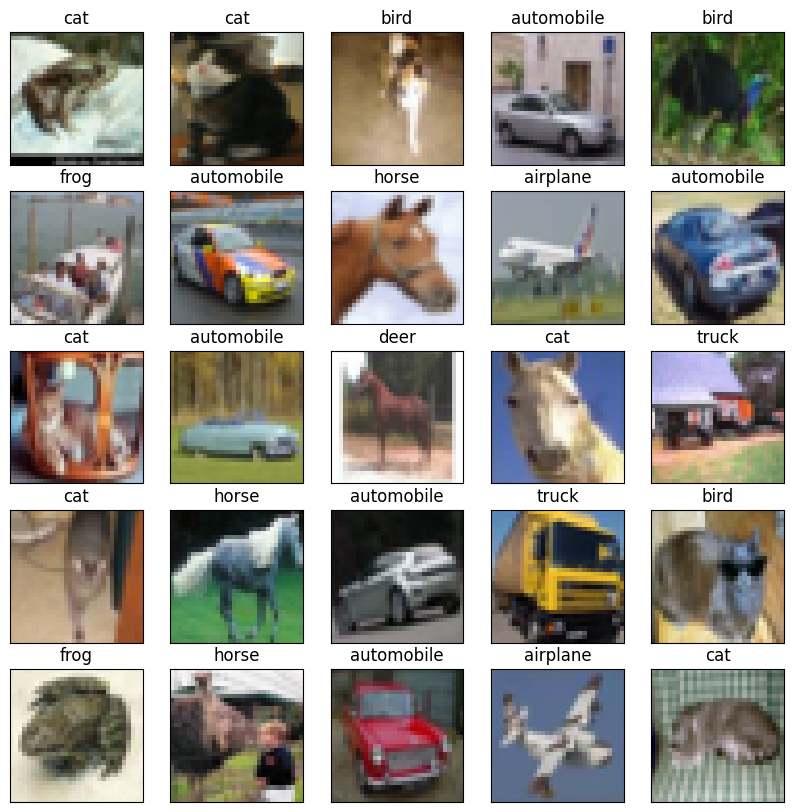

In [43]:
n_image = 25

# ランダムに25個取得
rand_idx = np.random.randint(0, len(x_test), n_image)

y_rand = model.predict(x_test[rand_idx])
predicted_class = np.argmax(y_rand, axis=1)

plt.figure(figsize=(10, 10))  # 画像の表示サイズ
for i in range(n_image):
    cifar_img=plt.subplot(5, 5, i+1)
    plt.imshow(x_test[rand_idx[i]])
    label = cifar10_labels[predicted_class[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

カエルをcat と識別するなど当たっていない事がわかる

## モデルの保存
学習済みのモデルをGoogle Driveに保存します。  

In [46]:
from google.colab import drive

# 全て許可しないと　MessageError: Error: credential propagation was unsuccessful が発生
drive.mount('/content/drive/')

Mounted at /content/drive/


In [48]:
import os
from keras.models import load_model

path = '/content/drive/My Drive/cnn_cifar10/'

# 下記は駄目
# path = '/content/drive/My Drive/Colab Notebooks/ai_master_course/Section_07'


# ディレクトリを作成　する
if not os.path.exists(path):
    os.makedirs(path)

# ファイルを保存する
# .h5 ファイルは、Kerasで学習済みのモデルを保存するための標準的なファイル形式
# HDF5 (Hierarchical Data Format version 5) というフォーマットに基づいており、モデルの構造、重み、学習の設定などを含んでいます。
# HDF5 は、大規模なデータセットや複雑なデータ構造を効率的に保存できるフォーマット(pickleよる効率が良い）
model.save(path + "model_cnn_cifar10.h5")

Google Driveを開いて、モデルが保存されたことを確認しましょう。